# 深度学习100例-卷积神经网络（CNN）识别眼睛状态 | 第17天

## 1.前期工作

### 1.1 导入数据

In [15]:
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

import os,PIL

# 设置随机种子尽可能使结果可以重现
import numpy as np
np.random.seed(1)

# 设置随机种子尽可能使结果可以重现
import tensorflow as tf
tf.random.set_seed(1)

import pathlib

《深度学习100例》第17天的数据链接如下：

https://pan.baidu.com/s/1IFusnsCrwMfl_12bWcefZg（提取码：86uu ）

In [16]:
data_dir = "F:\DeepLearning\day-17\eye_dataset"

data_dir = pathlib.Path(data_dir)

### 1.2 查看数据

In [17]:
image_count = len(list(data_dir.glob('*/*')))

print("图片总数为：",image_count)

图片总数为： 4308


## 2.数据预处理

### 2.1加载数据

使用`image_dataset_from_directory`方法将磁盘中的数据加载到`tf.data.Dataset`中

In [18]:
batch_size = 64
img_height = 224
img_width = 224

TensorFlow版本是2.2.0的同学可能会遇到`module 'tensorflow.keras.preprocessing' has no attribute 'image_dataset_from_directory'`的报错，升级一下TensorFlow就OK了。

In [19]:
"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789
"""
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 4308 files belonging to 4 classes.
Using 3447 files for training.


In [20]:
"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789
"""
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 4308 files belonging to 4 classes.
Using 861 files for validation.


我们可以通过class\_names输出[数据集](https://so.csdn.net/so/search?q=%E6%95%B0%E6%8D%AE%E9%9B%86&spm=1001.2101.3001.7020)的标签。标签将按字母顺序对应于目录名称。

In [21]:
class_names = train_ds.class_names
print(class_names)

['close_look', 'forward_look', 'left_look', 'right_look']


### 2.2可视化数据

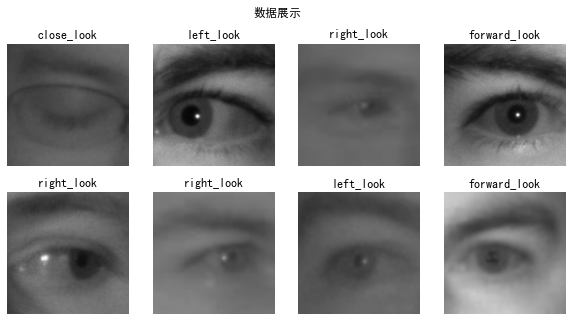

In [22]:
plt.figure(figsize=(10, 5))  # 图形的宽为10高为5
plt.suptitle("数据展示")

for images, labels in train_ds.take(1):
    for i in range(8):
        
        ax = plt.subplot(2, 4, i + 1)  
        
        ax.patch.set_facecolor('yellow')
        
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        
        plt.axis("off")

### 2.3再次检查数据

In [23]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 224, 224, 3)
(64,)


- `Image_batch`是形状的张量（8, 224, 224, 3\)。这是一批形状240x240x3的8张图片（最后一维指的是彩色通道RGB）。
- `Label_batch`是形状（8，）的张量，这些标签对应8张图片

### 2.4配置数据集

 -    **shuffle\(\)** ： 打乱数据，关于此函数的详细介绍可以参考：https://zhuanlan.zhihu.com/p/42417456
 -    **prefetch\(\)** ：预取数据，加速运行，其详细介绍可以参考我前两篇文章，里面都有讲解。
 -    **cache\(\)** ：将数据集缓存到内存当中，加速运行

In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

如果报 `AttributeError: module 'tensorflow._api.v2.data' has no attribute 'AUTOTUNE'` 错误，将 `AUTOTUNE = tf.data.AUTOTUNE` 更换为 `AUTOTUNE = tf.data.experimental.AUTOTUNE`，这个错误是由于版本问题引起的。

## 3.调用官方网络模型

In [25]:
model = tf.keras.applications.VGG16()
# 打印模型信息
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## 4.设置动态学习率

这里先罗列一下学习率大与学习率小的优缺点。

- 学习率大
  - 优点：1、加快学习速率。2、有助于跳出局部最优值。
  - 缺点：1、导致模型训练不收敛。2、单单使用大学习率容易导致模型不精确。
- 学习率小
  - 优点：1、有助于模型收敛、模型细化。2、提高模型精度。
  - 缺点：1、很难跳出局部最优值。2、收敛缓慢。

注意：这里设置的动态学习率为：指数衰减型（ExponentialDecay）。**假设1个epoch有100个batch（相当于100step），20个epoch过后，step==2000，即step会随着epoch累加**。计算公式如下：

> learning\_rate = initial\_learning\_rate \* decay\_rate \^ \(step / decay\_steps\)

In [26]:
# 设置初始学习率
initial_learning_rate = 1e-4

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, 
        decay_steps=20,      # 敲黑板！！！这里是指 steps，不是指epochs
        decay_rate=0.96,     # lr经过一次衰减就会变成 decay_rate*lr
        staircase=True)

# 将指数衰减学习率送入优化器
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

## 5.编译

在准备对模型进行训练之前，还需要再对其进行一些设置。以下内容是在模型的编译步骤中添加的：

 -    损失函数（loss）：用于衡量模型在训练期间的准确率。
 -    优化器（optimizer）：决定模型如何根据其看到的数据和自身的损失函数进行更新。
 -    评价函数（metrics）：用于监控训练和测试步骤。以下示例使用了准确率，即被正确分类的图像的比率。

In [27]:
model.compile(optimizer=optimizer,
              loss     ='sparse_categorical_crossentropy',
              metrics  =['accuracy'])

## 6.训练模型

In [28]:
epochs = 1

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

54/54 [==============================] - 2186s 38s/step - loss: 0.8497 - accuracy: 0.7447 - val_loss: 0.1996 - val_accuracy: 0.9292


## 7.模型评估

### 7.1Accuracy与Loss图

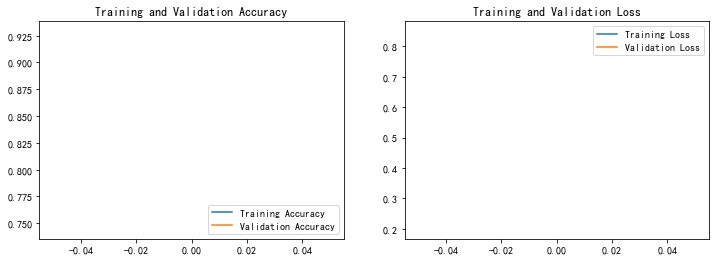

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 7.2 混淆矩阵

Seaborn 是一个画图库，它基于 Matplotlib 核心库进行了更高阶的 API 封装，可以让你轻松地画出更漂亮的图形。Seaborn 的漂亮主要体现在配色更加舒服、以及图形元素的样式更加细腻。

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# 定义一个绘制混淆矩阵图的函数
def plot_cm(labels, predictions):
    
    # 生成混淆矩阵
    conf_numpy = confusion_matrix(labels, predictions)
    # 将矩阵转化为 DataFrame
    conf_df = pd.DataFrame(conf_numpy, index=class_names ,columns=class_names)  
    
    plt.figure(figsize=(8,7))
    
    sns.heatmap(conf_df, annot=True, fmt="d", cmap="BuPu")
    
    plt.title('混淆矩阵',fontsize=15)
    plt.ylabel('真实值',fontsize=14)
    plt.xlabel('预测值',fontsize=14)

In [34]:
val_pre   = []
val_label = []

for images, labels in val_ds:#这里可以取部分验证数据（.take(1)）生成混淆矩阵
    for image, label in zip(images, labels):
        # 需要给图片增加一个维度
        img_array = tf.expand_dims(image, 0) 
        # 使用模型预测图片中的人物
        prediction = model.predict(img_array)

        val_pre.append(class_names[np.argmax(prediction)])
        val_label.append(class_names[label])

1/1 [==============================] - 0s 179ms/step


1/1 [==============================] - 0s 158ms/step


1/1 [==============================] - 0s 184ms/step


1/1 [==============================] - 0s 166ms/step


1/1 [==============================] - 0s 158ms/step


1/1 [==============================] - 0s 171ms/step


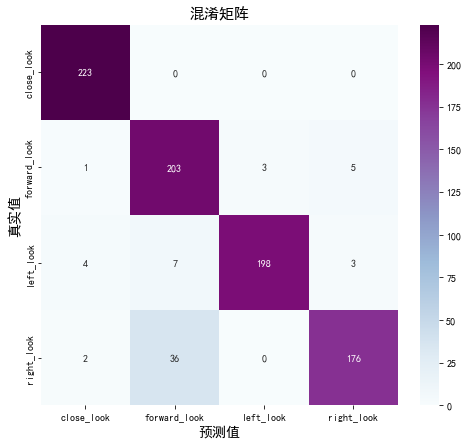

In [35]:
plot_cm(val_label, val_pre)

## 8.保存和加载模型

In [36]:
# 保存模型
model.save('model/17_model.h5')

In [37]:
# 加载模型
new_model = tf.keras.models.load_model('model/17_model.h5')

## 9.预测

1/1 [==============================] - 0s 305ms/step


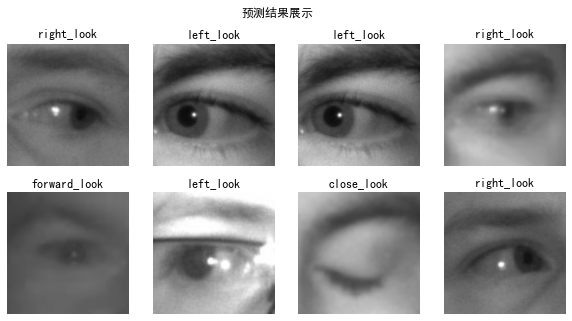

In [38]:
# 采用加载的模型（new_model）来看预测结果

plt.figure(figsize=(10, 5))  # 图形的宽为10高为5
plt.suptitle("预测结果展示")

for images, labels in val_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)  
        
        # 显示图片
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # 需要给图片增加一个维度
        img_array = tf.expand_dims(images[i], 0) 
        
        # 使用模型预测图片中的人物
        predictions = new_model.predict(img_array)
        plt.title(class_names[np.argmax(predictions)])

        plt.axis("off")